In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import h5py
import george
import matplotlib.pyplot as plt
import corner

% matplotlib notebook

#import mpld3
#mpld3.enable_notebook()

import sys
sys.path.insert(0, '../code/')

import run_plotting
import run_gp

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/dynesty/bounding.py:73: UserWarning: Robust OAS shrunk covariance estimator from `sklearn` is not available. Defaulting to MLE estimator from `numpy`.
  warnings.warn("Robust OAS shrunk covariance estimator from `sklearn` is "


In [3]:
#read in the data
obs_files = list()

import glob, os

for file in glob.glob("../data/paper_plots/ztf_lightcurves/*k2.txt.h"):
    obs_files.append(file)

print(obs_files)

for i in np.arange(len(obs_files)):
    print(obs_files[i])

    time, flux, flux_err = run_gp.read_data(obs_files[i], whitespace=True)




[]


# Make results plots by running the following cells.

In [4]:
files = list()
import glob, os

for file in glob.glob("../data/paper_plots/ztf_lightcurves/*k2.txt.hdf5"):
    files.append(file)
    
files

['../data/paper_plots/ztf_lightcurves/11351_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/11395_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/11397_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/1173_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/12929_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/1437_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/16596_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/16974_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/17172_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/18046_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/1873_k2.txt.hdf5',
 '../data/paper_plots/ztf_lightcurves/21601_k2.txt.hdf5']

In [24]:
filename = files[1]
filename#"../data/paper_plots/ztf_lightcurves/1437.txt.hdf5"
#filename = "../data/paper_plots/3200/ztf-lsst/burn_in_10k/3200_lc_49627_to_49787.txt_sampled_ztf-lsst_10days.txt.hdf5"

'../data/paper_plots/ztf_lightcurves/11395_k2.txt.hdf5'

    'mean:value',

    'kernel:k1:k1:log_constant',

    'kernel:k1:k2:metric:log_M_0_0',

    'kernel:k2:k1:log_constant',

    'kernel:k2:k2:gamma',

    'kernel:k2:k2:log_period')

In [15]:
def plot_posterior(data, true_period=None, legend=True, colours=None):
    """
    Plot a histogram of the posterior distribution, showing the full distribution,
    the 5th-95th percentile of the distribution, and a zoomed-in view of
    the region with the highest probability (or region around the period if specified).

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    true_period : float
        The period (in hours) around which to calculate the probability.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot


    """

    if colours is None:
        colours = ["black", "#0072B2", "#E69F00", "#009E73", "#F0E442"]

    fig, (ax, bx, cx) = plt.subplots(1, 3, figsize=(15,4))

    # plot the full histogram of period results
    flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])

    ax.hist(flat_data[:,-1], bins='auto', density=True, color=colours[0], alpha=0.3)

    if true_period:
        ylim = ax.get_ylim()
        ax.vlines(true_period, 0, ylim[-1], lw=1, color=colours[1], linestyle="dashed", label="true period : %.5f" %true_period)

    ax.set_xlabel("Period in hours")
    ax.set_ylabel("Probability")
    ax.set_ylim(ax.get_ylim())
    ax.set_title("Posteriod Period Distibution")

    # plot the 5th-95th percentile
    lower, upper = np.percentile(data[:,:,3], [5,95])
    masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]

    bx.hist(masked_data[:,-1], bins='auto', density=True, color=colours[0], alpha=0.3)

    if true_period:
        ylim = bx.get_ylim()
        bx.vlines(true_period, 0, ylim[-1], lw=1, color=colours[1], linestyle="dashed", label="true period : %.5f" %true_period)

    bx.set_title("5th - 95th Percentile")
    bx.set_xlabel("Period in hours")
    bx.set_ylabel("Probability")
    bx.set_ylim(bx.get_ylim())

    # zoom in on the part of the graph that has the highest probability
    prob, edges = calc_prob(masked_data, true_period, plot=False)

    if prob==0:
            raise Exception('WARNING: Probability around period is 0 and therefore cannot display a valid corner plot.')

    zoom_data = data[(data[:,:,-1]>edges[0]) & (data[:,:,-1]<edges[1])]

    best_period = np.percentile(zoom_data[:,-1], 50)
    
    print(best_period)

    cx.hist(zoom_data[:,-1], bins='auto', density=True, color=colours[0], alpha=0.3)
    ylim = cx.get_ylim()

    if true_period:
        cx.vlines(true_period, 0, ylim[-1], lw=1, color=colours[1], linestyle="dashed", label="true period : %.5f" %true_period)
        cx.vlines(best_period, 0, ylim[-1], lw=1, color=colours[2], linestyle="dashed", label="best period : %.5f" %best_period)
    else:
        cx.vlines(best_period, 0, ylim[-1], lw=1, color=colours[2], linestyle="dashed", label="best period : %.5f" %best_period)
    cx.set_title("Probability %.3f" %prob)
    cx.set_xlabel("Period in hours")
    cx.set_ylabel("Probability")
    cx.set_ylim(ylim)

    if legend:
        ax.legend()
        bx.legend()
        cx.legend()

    plt.tight_layout()
    #plt.savefig(namestr + "_period_pdf.pdf", format="pdf")

    return best_period



In [16]:

def plot_folded_lightcurve(time, flux, period, flux_err=None, models=None, true_lightcurve=None, ax=None, use_radians=False, legend=True, colours=None):
    """
    Plot a folded periodic light curve, potentially including the true underlying
    model that produced the data (in the case of simulations), or model
    light curves from MCMC.

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    period : float
        The period on which to fold **in hours**

    models : iterable of shape (model_time, numpy.ndarray of shape (nsamples, len(model_time)))
        First element here contains the time stamps for the models (which may not be the same
        as for the data), the second is an array of shape (nsamples, ndatapoints), where nsamples
        is the number of model light curves, and ndatapoints == len(model_time)

    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the
        simulated data was created (could be higher-resolution than the "data"), useful for
        comparison between models created e.g. from MCMC samples and the true underlying process


    ax : matplotlib.Axes object
        An Axes object in which to plot the results. If not given, the code will create a
        new figure.

    use_radians : bool, default False
        If True, the phase will be plotted from (0, 2pi) instead of (0,1), which is the default.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    Returns
    -------

    ax : matplotlib.Axes object
        The object with the plot

    """

    if colours is None:
        colours = ["#000000", "#0072B2", "#E69F00", "#009E73", "#F0E442"]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4))

    period_days = period/24.

    t0 = np.min(time)
    if models:
        t0 = np.min([t0, np.min(models[0])])

    if true_lightcurve:
        t0 = np.min([t0, np.min(true_lightcurve[0])])

    phase = (time-t0)/period_days - np.floor((time-t0)/period_days)

    if use_radians:
        phase *= 2.*np.pi

    if flux_err is None:
        ax.scatter(phase, flux, s=5, color=colours[0], label="Observations")
    else:
        ax.errorbar(phase, flux, yerr=flux_err, fmt="o", c=colours[0], markersize=5, label="Observations")

    if true_lightcurve:
        true_time = (true_lightcurve[0] - t0)
        true_flux = true_lightcurve[1]
        true_phase = true_time/period_days - np.floor(true_time/period_days)

        if use_radians:
            true_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(true_phase)
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]

        # loop through indices where phase goes from 1 (or 2pi) to 0
        # plot each phase light curve separately
        istart = 0
        iend = idx[0]+1

        # first phase cycle also contains the label for the legend
        ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3,
                c=colours[1], label="True Lightcurve")

        for i, x in enumerate(idx[:-1]):
            ax.plot(true_phase[istart:iend], true_flux[istart:iend], alpha=0.3, c=colours[1], label="")
            istart = x+1
            iend = idx[i+1]+1

        # last plot
        istart = idx[-1]+1
        ax.plot(true_phase[istart:], true_flux[istart:], alpha=0.3, c=colours[1], label="")

    if models:

        m_time = (models[0] - t0)
        m_flux = models[1]

        m_phase = (m_time/period_days) - np.floor(m_time/period_days)
        print("mphase " + str(m_phase))
        if use_radians:
            m_phase *= 2.*np.pi

        # compute the difference from one phase bin to the next
        tdiff = np.diff(m_phase)

        print("tdiff " + str(tdiff))
        # find all differences < 0, which is where the phase wraps around
        idx = np.where(tdiff < 0)[0]
        #if idx.size == 0:
        #    idx = np.array(0)

        # loop through the different samples
        for i,m in enumerate(m_flux):
            # loop through indices where phase goes from 1 (or 2pi) to 0
            # plot each phase light curve separately
            istart = 0
            iend = idx[0]+1

            if i == 0:
                # first phase cycle also contains the label for the legend
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="model")

            else:
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="")

            for j, x in enumerate(idx[:-1]):
                ax.plot(m_phase[istart:iend], m[istart:iend], alpha=0.1,
                        c=colours[2], label="")

                istart = x+1
                iend = idx[j+1]+1

            # last plot
            istart = idx[-1]+1
            ax.plot(m_phase[istart:], m[istart:], alpha=0.1, c=colours[2], label="")

    if legend:
        ax.legend()
    ax.set_xlabel("Rotational Phase")
    ax.set_ylabel("Flux")
    ax.set_title(r"period $P = %.5f$"%period)
    if use_radians:
        ax.set_xlim(0, 2*np.pi)
    else:
        ax.set_xlim(0, 1)
    return ax



In [17]:
def run_lsp(time, flux, flux_err=None, data=None, true_period=0, true_lightcurve=None, use_radians=False, legend=True, colours=None, plot=False):
    """
    Determine the Lomb-Scargle Periodogram (nterms = 1-3) for the light curve data
    and plot the frequencies as well as the a folded light curve using

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    true_period : float
        The period on which to fold in hours

    true_lightcurve : iterable containing (true_time, true_flux)
        In the case of simulated data, this contains the times and flux values from which the
        simulated data was created (could be higher-resolution than the "data"), useful for
        comparison between models created e.g. from MCMC samples and the true underlying process

    use_radians : bool, default False
        If True, the phase will be plotted from (0, 2pi) instead of (0,1), which is the default.

    legend : bool, default True
        If True, include a legend in the plot

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.

    plot : bool
        Do you want a plot?

    Returns
    -------

    figure : matplotlib.figure.Figure
        The object with the plot

    lsp_period : numpy.ndarray
        An array of the periods calculated from the Lomb-Scargle periodograms with corresponding
        n_terms [1,2,3].
    """

    if colours == None:
        colours = ["#000000", "#0072B2", "#E69F00", "#009E73", "#F0E442"]

    from scipy.signal import argrelextrema

    #get l-s best period estimate
    from lombscargle import make_lsp
    from astropy.stats import LombScargle


    if data is not None:
        lower, upper = np.percentile(data[:,:,3], [5,95])
        masked_data = data[(data[:,:,3]>lower) & (data[:,:,3]<upper)]

    lsp_periods = np.array([])

    if plot:
        fig, ax = plt.subplots(3,2, figsize=(10,10))

    for i in np.arange(3):
        freq, power = make_lsp(time, flux, flux_err, p_max=5.0, nterms=(i+1))

        # determine the indices of local power maxima
        best_idx = argrelextrema(power, np.greater)

        # sort these indices based on actual power value
        # reverse list so max is read first
        indices = np.argsort(power[best_idx[0]])[::-1]

        # sort our original indices based on the new
        # power-sorted indices
        best_idx = (best_idx[0]).T[indices]
        best_freqs = freq[best_idx].T

        new_freq = best_freqs[0]
        new_period = 1./new_freq
        new_log_period = np.log(1./new_freq)

        if plot:

            # plot all the frequencies
            ax[i][0].plot((1./freq)*24., power, color=colours[0], alpha=0.7)

            if data is not None:
                ax[i][0].hist(masked_data[:,-1], bins=20, color=colours[3], alpha=0.5, density=True, label="Posterior")

            y_max = (ax[i][0].get_ylim())[1]

            ax[i][0].vlines(new_period*24., 0, y_max, colors=colours[2], linestyles='--',
                      label = 'Best fit : %.5f' %(new_period*24.))

            if true_period:
                ax[i][0].vlines(true_period, 0,  y_max, colors=colours[1], linestyles='--',
                      label = 'True fit : %.5f' %true_period)


            ax[i][0].set_xlabel('Period (hrs)')
            ax[i][0].set_ylabel("Normalized Power")
            ax[i][0].set_title("nterms = %s" %(i+1))
            ax[i][0].set_xlim([0,24])
            ax[i][0].set_ylim([0, y_max])

            if legend:
                ax[i][0].legend()

            plot_folded_lightcurve(time, flux, period=new_period*24., ax=ax[i][1], true_lightcurve=true_lightcurve, use_radians=use_radians, legend=False)

        lsp_periods = np.append(lsp_periods, new_period*24.)

    #fig.suptitle("Lomb-Scargle Periodogram", fontsize=20)
    if plot:
        plt.tight_layout()


    return lsp_periods



In [18]:
def plot_corner(data, gp, true_period=None, colours=None, zoom=False, trim=None, fig=None, legend=True):
    """
    Plot a corner plot showing the projections of a data set in multi-dimesional space,
    with the different dimensions corresponding to the different kernel parameters.

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    gp :  GP object
        The basic Gaussian Process object.

    true_period : float
        The true period of the asteroid light curves.

    colours : [str, str, str]
        List of (up to) three colours. First colour is used for the data, the second
        colour for the true underlying data, the third for the models.
        Note, for a corner plot, the first colour will always default to black.
        Only the second true underlying data color can be changed.

    zoom : bool
        Toggles whether the corner plot will show a zoomed in version of the histogram,
        focusing on the densest region of the previous binned histogram.

    trim : [float, float]
        Specifies what percentile range of the period is to be used for plotting.
        This can be used to eliminate extreme outliers that would otherwise distort the plot.

    Returns
    -------

    figure : matplotlib.figure.Figure
        The object with the plot

    """

    if colours == None:
        colours = ["#000000", "#0072B2", "#E69F00", "#009E73", "#F0E442"]

    if trim:

        try:
            lower, upper = np.percentile(data[:,:,-1], [trim[0],trim[1]])
            flat_data = data[(data[:,:,-1]>lower) & (data[:,:,-1]<upper)]

        except TypeError:
            print("ERROR: Values for trim must be formatted as an array (e.g. [5], not 5).\n Plot will be processed without any trimming.")
            flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])

        except IndexError:
            print("WARNING: No upper percentile was specified. Upper percentile was set to 100.")
            trim = np.append(trim, 100)
            lower, upper = np.percentile(data[:,:,-1], [[0],trim[1]])

            flat_data = data[(data[:,:,-1]>lower) & (data[:,:,-1]<upper)]

    else:
        flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])

    if zoom:
        prob, edges = calc_prob(data, period=true_period)

        if prob==0:
            raise Exception('WARNING: Probability around period is 0 and therefore cannot display a valid corner plot.')

        flat_data = data[(data[:,:,-1]>edges[0]) & (data[:,:,-1]<edges[1])]

    #get label names from the gp object
    labels = ['mean', 'log_amp', 'metric', 'log_amp_2', 'gamma', 'period']
    labels[-1] = 'period hours'

    figure = corner.corner(flat_data, labels=labels, show_titles=legend, title_kwargs={"fontsize": 8}, fig=fig)

    return figure



In [19]:
def plot_trace(data, iterations, colours=None):
    """
    Create a plot of walker movement after the burn-in period.

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    iterations : int
        The number of iterations the MCMC code was run for. Can use data.shape[1].

    colours : [str]
        One colour. First colour is used for the data.

    Returns
    -------

    fig : matplotlib.figure.Figure
        The object with the plot

    """

    if colours is None:
        colours = ["black"]

    dims = ['mean', 'log_amp', 'metric', 'log_amp_2', 'gamma', 'period']

    fig, ax = plt.subplots(2,3, figsize=(9,5))
    fig.subplots_adjust(wspace=0.5, hspace=0.3)
    axs = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]]

    x = np.arange(iterations)

    for i in range(data.shape[2]):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(data.shape[0]):
            param = data[j,:,i]
            axs[i].plot(x, param, color=colours[0], alpha=0.3)

    return fig

In [20]:
def set_kernel(time, flux, flux_err):
    """
    Set up the Gaussian Process kernel from original light curve data,
    because it couldn't be saved to an hdf5 file.

    Parameters
    ----------
    time : numpy.ndarray
        The time stamps of the periodic light curve

    flux : numpy.ndarray
        Flux measurements corresponding to the time stamps

    flux_err : numpy.ndarray
        The flux uncertainties corresponding to the data.

    Returns
    -------

    gp : GP object
        The basic Gaussian Process object.

    """

    # calculate hyperparameter estimates from light curve data
    mean_flux = np.mean(flux)

    # k1
    log_amp_k1 = np.log(flux.max()-flux.min())
    metric = 5**2

    # k2
    log_amp_k2 = np.log(0.5)
    gamma = 10
    log_period = np.log(6/24.)

    params = {"mean": mean_flux, "log_amp_k1": log_amp_k1, "metric": metric, "log_amp_k2": log_amp_k2, "gamma": gamma,"log_period": log_period}

    """Calculates initial gp parameter values based on data."""
    k1 = np.mean(flux) * george.kernels.ExpSquaredKernel(metric=10**2)
    k2 = 0.5 * george.kernels.ExpSine2Kernel(gamma=7, log_period=np.log(3/24.))

    kernel = k1+k2

    gp = george.GP(kernel, mean=np.mean(flux), fit_mean=True)

    gp.compute(time, flux_err)



In [21]:

def calc_prob(data, period=None, p_range=None, bins=10000, width=0.1, plot=False):
    """
    Calculated the probability of an interval of periods.

    Parameters
    ----------
    data : numpy.ndarray
        Results pulled from hdf5 file. Assumes the shape to be [nwalkers, iterations, parameters].

    period : float
        The period (in hours) around which to calculate the probability.

    p_range : list
        List of starting and ending values for an interval.

    bins : int
        The number of bins to calculate with for the numpy histogram. It's best to keep this number very large.

    width : float
        The distance on either side of the period over which will be integrated. Width will be ignored
        if p_range is specified.

    plot : bool, default False
        Returns a plot of the area of the posterior distribution being integrated.

    Returns
    -------

    prob : numpy.float64
        Total integrated area (probability) of the posterior period distribution within the edges listed.

    edges : list
        List of starting and ending values for the interval used to calculate the probability.
        This will be the same as p_range if p_range was specified.

    """

    #flat_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    flat_data = data
    
    print(flat_data[:,-1])

    h, bins = np.histogram(flat_data[:,-1], bins=bins, density=True, )

    if period:

        edges = [period-width, period+width]
        idx = np.searchsorted(bins, edges, side="left")
        h_i = np.sum(h[idx[0]: idx[1]])


    elif p_range:

        edges = p_range
        idx = np.searchsorted(bins, edges, side="left")
        h_i = np.sum(h[idx[0]: idx[1]])


    else:
        #find the period of hmax
        period = bins[np.abs(h - h.max()).argmin()]
        print(period)

        edges = [period-width, period+width]
        idx = np.searchsorted(bins, edges, side="left")
        h_i = np.sum(h[idx[0]: idx[1]])


    dx = bins[1]-bins[0]

    prob = h_i*dx

    if plot:
        fig, (ax, bx) = plt.subplots(1,2, figsize=(10,5))
        ax.bar(bins[idx[0]: idx[1]], h[idx[0]: idx[1]], width=dx)

        bx.bar(bins[0:-1], h, width=dx)


    return prob, edges



(100, 10000, 6)


[4.00275012 4.00275012 4.00275012 ... 7.9453994  7.9453994  7.9453994 ]
5.964690487696048
5.9680405534268735


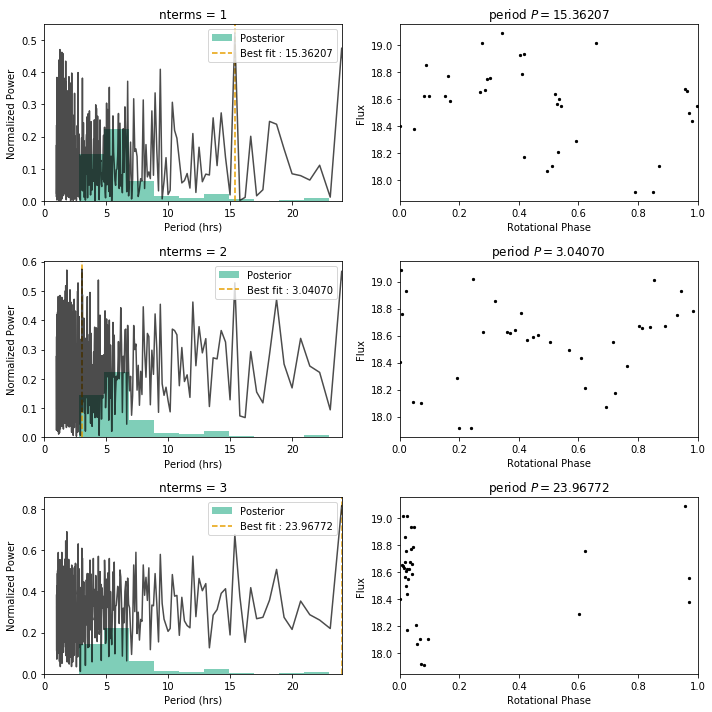

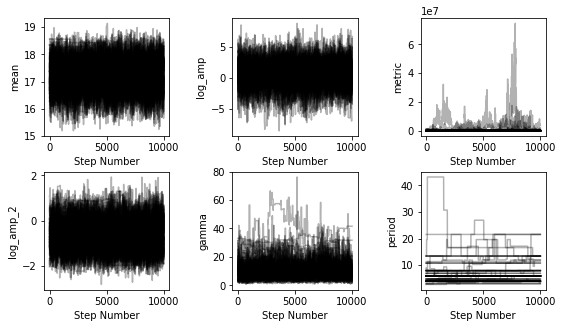

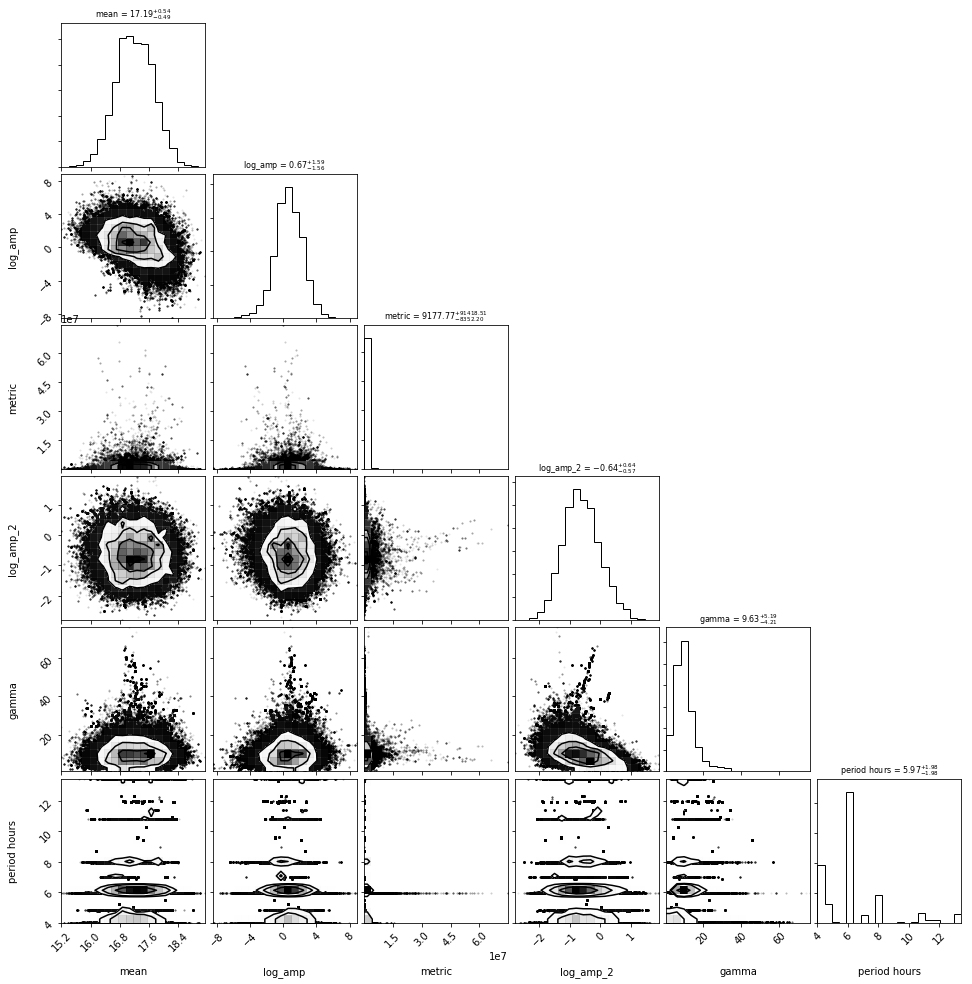

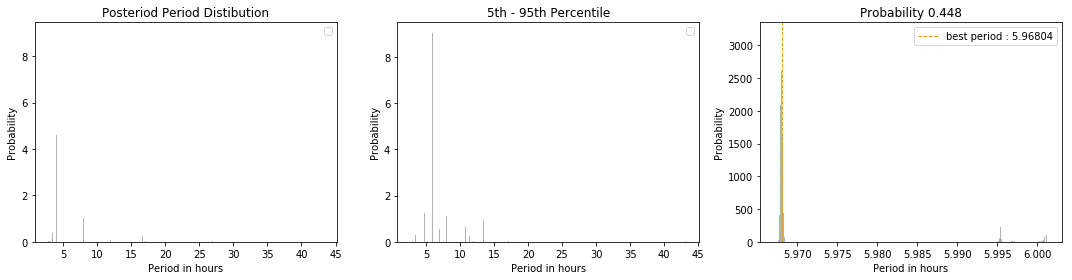

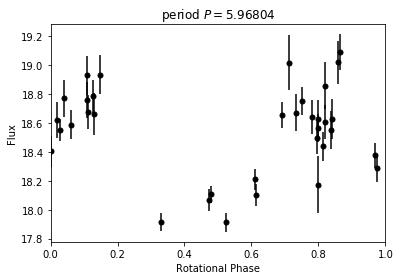

In [23]:
with h5py.File(filename, "r") as f:
        data = f['chain'][:]
        time = f['time'][:]
        flux = f["flux"][:]
        flux_err = f['flux_err'][:]
        iterations = data.shape[1]
        true_period=None
        true_lightcurve=None
        
        # convert period from log_days to hours
        data[:,:,-1] = np.exp(data[:,:,-1])*24.
        
        print(data.shape)
        #plot_trace(data, iterations)
        gp = set_kernel(time, flux, flux_err)
        
        ###   LOMB-SCARGLE   ###
        lsp = run_lsp(time, flux, flux_err, data, true_period, true_lightcurve, plot=True)
        #plt.savefig(filename + "_lsp.pdf", format="pdf")

        
        
        ###   TRACE PLOT   ###
        plot_trace(data, f.attrs['iterations'])
        #plt.savefig(filename + "_trace.pdf", format="pdf")


        ###   CORNER PLOTS   ###
        #plot_corner(data, gp, true_period, legend=True)
        #plt.savefig(filename + "_corner.pdf", format="pdf")

        plot_corner(data, gp, true_period, trim=[5,95], legend=True)
        #plt.savefig(filename + "_corner_5_95.pdf", format="pdf")

        #plot_corner(data, gp, true_period, zoom=True, legend=True)
        #plt.savefig(filename + "_corner_zoom.pdf", format="pdf")


        ###   POSTERIOR   ###
        best_period = plot_posterior(data, true_period)
        #plt.savefig(filename + "_posterior.pdf", format="pdf")

        #best_period=6.8555
        ###   FOLDED LIGHTCURVE   ###
        plot_folded_lightcurve(time, flux, flux_err=flux_err, legend=False,
                                            period=best_period, true_lightcurve=true_lightcurve)
        
        
        #plt.savefig(filename + "_folded.pdf", format="pdf")

In [158]:
plt.plot(time, flux, ".")
plt.show()